# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [ ]:
import re
import json
import requests
import textdistance
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import contextily as ctx
from tqdm import tqdm
from collections import Counter
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [3]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [4]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [5]:
pd.set_option('display.max_rows', 20)

### 0. General stats

total number of triples in KG (sanity test) = number of edges (predicates in triples)

In [6]:
query = ''' SELECT (COUNT(?p) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,2548822


number of classes

In [7]:
query = ''' SELECT (COUNT(DISTINCT ?class) AS ?count)
            WHERE {
                ?class a rdfs:Class .
                FILTER(!isBlank(?class))  # exclude blank nodes
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,16


show them

In [8]:
query = ''' SELECT ?class
            WHERE {
                ?class a rdfs:Class .
                FILTER(!isBlank(?class))
            } '''
run_minmod_query(query)

,class.type,class.value
0,uri,https://minmod.isi.edu/resource/MineralInventory
1,uri,https://minmod.isi.edu/resource/MineralSite
2,uri,https://minmod.isi.edu/resource/Unit
3,uri,https://minmod.isi.edu/resource/Reference
4,uri,https://minmod.isi.edu/resource/Grade
5,uri,https://minmod.isi.edu/resource/DepositType
6,uri,https://minmod.isi.edu/resource/Document
7,uri,https://minmod.isi.edu/resource/MappableCriteria
8,uri,https://minmod.isi.edu/resource/ResourceReserv...
9,uri,https://minmod.isi.edu/resource/GeologyInfo


number of instances (subjects with a specific type, excluding literals and blank nodes)

In [9]:
query = ''' SELECT (COUNT(DISTINCT ?instance) AS ?count)
            WHERE {
                ?instance a ?type .
                FILTER(!isBlank(?instance))
                FILTER(!isLiteral(?instance))
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,250119


number of blank nodes (subjects or objects that are not URIs or literals)

In [10]:
query = ''' SELECT (COUNT(?s) AS ?countSubjects) (COUNT(?o) AS ?countObjects)
            WHERE {
                { ?s ?p ?o FILTER(isBlank(?s)) }
                UNION
                { ?s ?p ?o FILTER(isBlank(?o)) }
            } '''
run_minmod_query(query)

,countSubjects.type,countSubjects.datatype,countSubjects.value,countObjects.type,countObjects.datatype,countObjects.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,1509971,literal,http://www.w3.org/2001/XMLSchema#integer,1509971


### 1. Deposit Types

In [11]:
query = '''
SELECT ?dep ?dname ?dgroup ?denv
WHERE {
    ?dep a              :DepositType .
    ?dep rdfs:label     ?dname .
    ?dep :deposit_group ?dgroup .
    ?dep :environment   ?denv .
} '''
run_minmod_query(query, values=True)

,dep.value,dname.value,dgroup.value,denv.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


search by string in all three vars (cols):

In [12]:
DEPOSIT_QUERY_TEMPLATE_ANY = '''
SELECT ?dep ?dname ?dgroup ?denv
WHERE {
    ?dep a              :DepositType .
    ?dep rdfs:label     ?dname .
    ?dep :deposit_group ?dgroup .
    ?dep :environment   ?denv .
    FILTER(
        CONTAINS(LCASE(?dname),  "%s") ||
        CONTAINS(LCASE(?dgroup), "%s") ||
        CONTAINS(LCASE(?denv),   "%s")
    )
} '''

In [13]:
search_string = 'mafic'

In [14]:
query = DEPOSIT_QUERY_TEMPLATE_ANY % ((search_string.lower(),) * 3)
run_minmod_query(query, values=True)

,dep.value,dname.value,dgroup.value,denv.value
0,https://minmod.isi.edu/resource/Q489,Impact U-M intrusion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic
1,https://minmod.isi.edu/resource/Q480,U-M layered intrusion iron-titanium- vanadium,Ultramafic and (or) mafic-layered intrusion,Magmatic
2,https://minmod.isi.edu/resource/Q409,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal
3,https://minmod.isi.edu/resource/Q376,Siliciclastic-mafic barite,Sediment-hosted,Basin hydrothermal
4,https://minmod.isi.edu/resource/Q477,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic
5,https://minmod.isi.edu/resource/Q485,Arc U-M intrusion titanium- vanadium,Ultramafic and (or) mafic intrusion,Magmatic
6,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic
7,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,Ultramafic and (or) mafic intrusion,Magmatic
8,https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic
9,https://minmod.isi.edu/resource/Q411,Bimodal-mafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal


### 2. Mineral Inventories

#### 2.1. Statistics

In [15]:
query = ''' SELECT ?commodity (COUNT(?o_inv) AS ?count)
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name ?commodity ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
            }
            GROUP BY ?commodity '''
run_minmod_query(query, values=True)

,commodity.value,count.value
0,Nickel,1186
1,Zinc,1252


#### 2.2. **Zinc** Ore values, from all inventories, & their grades, for inventories with grade >= 5

In [16]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                FILTER (?grade >= 5)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cat.value
0,https://minmod.isi.edu/resource/invn__Q589__c_...,6.6,6.4,https://minmod.isi.edu/resource/INDICATED
1,https://minmod.isi.edu/resource/invn__Q589__c_...,6.6,6.4,https://minmod.isi.edu/resource/MEASURED
2,https://minmod.isi.edu/resource/mineral_invent...,77100,9.99,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/invn__Q589__c_...,0.83,5.0,https://minmod.isi.edu/resource/INDICATED
4,https://minmod.isi.edu/resource/invn__Q589__c_...,0.83,5.0,https://minmod.isi.edu/resource/MEASURED
...,...,...,...,...
333,https://minmod.isi.edu/resource/invn__Q589__c_...,18.27,6.62,https://minmod.isi.edu/resource/MEASURED
334,https://minmod.isi.edu/resource/invn__Q589__c_...,6.15,12.14,https://minmod.isi.edu/resource/INDICATED
335,https://minmod.isi.edu/resource/invn__Q589__c_...,6.15,12.14,https://minmod.isi.edu/resource/MEASURED
336,https://minmod.isi.edu/resource/invn__Q589__c_...,0.91,6.06,https://minmod.isi.edu/resource/INDICATED


#### 2.3. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [17]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/mineral_invent...,327847000,0.216,0.6,https://minmod.isi.edu/resource/indicated
1,https://minmod.isi.edu/resource/mineral_invent...,1.1,1.01,0.7,https://minmod.isi.edu/resource/inferred
2,https://minmod.isi.edu/resource/mineral_invent...,53000,0.18,0.59,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/mineral_invent...,16508000,0.34,0.2,https://minmod.isi.edu/resource/indicated
4,https://minmod.isi.edu/resource/mineral_invent...,7163000,1.11,0.5,https://minmod.isi.edu/resource/inferred
...,...,...,...,...,...
102,https://minmod.isi.edu/resource/mineral_invent...,2705000,0.95,0.83,https://minmod.isi.edu/resource/inferred
103,https://minmod.isi.edu/resource/mineral_invent...,134,0.25,19,https://minmod.isi.edu/resource/inferred
104,https://minmod.isi.edu/resource/mineral_invent...,190,0.24,0.6,https://minmod.isi.edu/resource/inferred
105,https://minmod.isi.edu/resource/mineral_invent...,41.1,0.28,26,https://minmod.isi.edu/resource/inferred


#### 2.4. All **Nickel** inventories

In [18]:
query = ''' SELECT ?ore ?grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity/:name "Nickel"@en .
                ?o_inv :ore/:ore_value ?ore .
                ?o_inv :grade/:grade_value ?grade .
            } '''
df = run_minmod_query(query, values=True)
df

,ore.value,grade.value,cat.value
0,327847000,0.216,https://minmod.isi.edu/resource/indicated
1,4.625,0.29,https://minmod.isi.edu/resource/Indicated
2,684.0,1.3,https://minmod.isi.edu/resource/Inferred
3,1.0,0.3,https://minmod.isi.edu/resource/Inferred
4,17.2,0.56,https://minmod.isi.edu/resource/Indicated
...,...,...,...
1181,33.3,0.81,https://minmod.isi.edu/resource/Inferred
1182,11.7,0.02,https://minmod.isi.edu/resource/Measured
1183,48.95,0.08,https://minmod.isi.edu/resource/Inferred
1184,5.643,1.5,https://minmod.isi.edu/resource/Indicated


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [ ]:
# query = ''' SELECT ?ci ?cn ?gi
#             WHERE {
#                 ?ci a :Commodity .
#                 ?ci :name ?cn .
#                 ?ci owl:sameAs ?gi .
#             } '''
# example_df = run_minmod_query(query)
# example_df

#### 3.2. get commodity symboles from `GeoKB`

In [ ]:
# def get_symbol_via_sparql(geokb_uri):
#     query = '''
#     SELECT ?symb
#     WHERE {
#         <%s> gkbt:P17 ?symb .
#     }''' % (geokb_uri)
#     result_record = run_geokb_query(query)
#     if len(result_record) > 0:
#         return result_record.iloc[0]['symb.value']
#     return ""

In [ ]:
# pd.set_option('display.max_rows', 500)

# example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
# example_df

### 4. Mineral Sites

#### 4.1. Nickel `MineralSite` instances

In [19]:
query = ''' SELECT ?ms ?msr ?mss ?loc_wkt
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
                ?ms :location_info [ :location ?loc_wkt ] .
                
                ?ms :mineral_inventory ?mi .
                ?mi :commodity [ :name "Nickel"@en ] .
            } '''
df_2 = run_minmod_query(query, values=True)
df_2

,ms.value,msr.value,mss.value,loc_wkt.value
0,https://minmod.isi.edu/resource/mineral_site9f...,10097104,MRDS,POINT (25.09406 -28.99506)
1,https://minmod.isi.edu/resource/mineral_site6a...,10069645,MRDS,POINT (125.58254 10.2506)
2,https://minmod.isi.edu/resource/mineral_sitefd...,10069268,MRDS,POINT (-88.41672 47.25)
3,https://minmod.isi.edu/resource/mineral_site45...,10182647,MRDS,POINT (59.83457 52.06465)
4,https://minmod.isi.edu/resource/mineral_site73...,10172207,MRDS,POINT (-90.429 37.43177)
...,...,...,...,...
2964,https://minmod.isi.edu/resource/mineral_site99...,10149641,MRDS,POINT (-117.19342 38.47053)
2965,https://minmod.isi.edu/resource/mineral_siteb7...,10303649,MRDS,POINT (-80.99008 46.55829)
2966,https://minmod.isi.edu/resource/mineral_site5f...,1,https://w3id.org/usgs/z/4530692/MTH2C7HU,"MULTIPOINT(-91.70833 47.78333,-91.79167 47.696..."
2967,https://minmod.isi.edu/resource/mineral_site08...,10095412,MRDS,POINT (-98.65606 54.87783)


visualize:

100%|██████████████████████████████████████████████████████████████████████████████| 2969/2969 [00:00<00:00, 139983.01it/s]


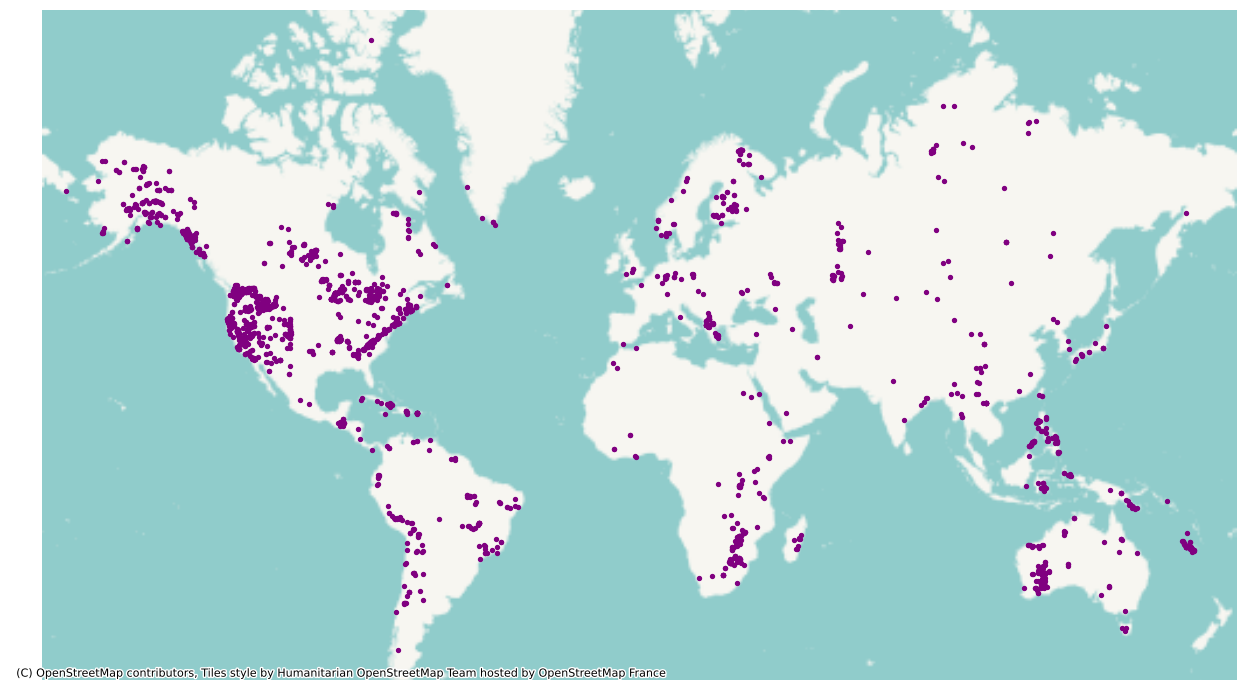

In [20]:
df_2['loc_wkt'] = df_2['loc_wkt.value'].progress_apply(safe_wkt_load)

sample_gdf = gpd.GeoDataFrame(df_2, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(16, 16))
sample_gdf.plot(ax=ax, color='purple', markersize=8)
ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

## Grade-Tonnage models

In [21]:
query = '''
SELECT 
  ?ms                                              # Mineral Site URI
  ?ms_name                                         # Mineral Site Name
  ?deposit_name                                    # Deposit Type Name
  ?country                                         # Country
  ?loc_wkt                                         # WKT Geometry
  ?total_tonnage_measured
  ?total_tonnage_indicated
  ?total_tonnage_inferred
  ?total_contained_measured
  ?total_contained_indicated
  ?total_contained_inferred
  (?total_tonnage_measured + ?total_tonnage_indicated + ?total_tonnage_inferred AS ?total_tonnage)                     # Total Tonnage [million tonnes]
  (?total_contained_measured + ?total_contained_indicated + ?total_contained_inferred AS ?total_contained_metal)
  (IF(?total_tonnage > 0, ?total_contained_metal / ?total_tonnage, 0) AS ?total_grade)                                 # Total Grade
WHERE {
  {
    SELECT ?ms ?ms_name ?deposit_name ?country ?loc_wkt
           (SUM(?tonnage_measured) AS ?total_tonnage_measured)
           (SUM(?tonnage_indicated) AS ?total_tonnage_indicated)
           (SUM(?tonnage_inferred) AS ?total_tonnage_inferred)
           (SUM(?contained_measured) AS ?total_contained_measured)
           (SUM(?contained_indicated) AS ?total_contained_indicated)
           (SUM(?contained_inferred) AS ?total_contained_inferred)
    WHERE {
        {
           SELECT ?ms (MAX(?confidence) AS ?max_confidence)
           WHERE {
              ?ms :deposit_type_candidate/:confidence ?confidence .
           }
           GROUP BY ?ms
        }
    
        ?ms :deposit_type_candidate ?deposit_candidate_with_max_conf .
        ?deposit_candidate_with_max_conf :confidence ?deposit_confidence .
        ?deposit_candidate_with_max_conf :normalized_uri [ rdfs:label ?deposit_name ] .
        FILTER(?deposit_confidence = ?max_confidence)
    
        ?ms :mineral_inventory ?mi .
        OPTIONAL { ?ms rdfs:label|:name ?ms_name . }
        OPTIONAL {
            ?ms :location_info [ :country ?country; :location ?loc_wkt ] .
            FILTER(datatype(?loc_wkt) = geo:wktLiteral)
        }
        
        ?mi :category ?mi_cat .
        ?mi :commodity [ :name "Nickel"@en ] .
    
        {
            SELECT ?mi (MAX(?ore_val) AS ?max_ore_val) (SAMPLE(?grade_val) AS ?matched_grade_val)
            WHERE {
                ?mi :ore [ :ore_value ?ore_val_raw; :ore_unit ?ore_unit] .
                OPTIONAL { ?mi :grade [ :grade_value ?grade_val; :grade_unit ?grade_unit] . }
                BIND(IF(bound(?ore_val_raw), ?ore_val_raw, 0) AS ?ore_val_pre)
                BIND(IF(?ore_unit = <https://minmod.isi.edu/resource/Q202>, ?ore_val_pre, IF(?ore_unit = <https://minmod.isi.edu/resource/Q200>, ?ore_val_pre / 1e6, ?ore_val_pre)) AS ?ore_val)
            }
            GROUP BY ?mi
        }
    
        BIND(IF(CONTAINS(LCASE(STR(?mi_cat)), "measured"), ?max_ore_val, 0) AS ?tonnage_measured)
        BIND(IF(CONTAINS(LCASE(STR(?mi_cat)), "indicated"), ?max_ore_val, 0) AS ?tonnage_indicated)
        BIND(IF(CONTAINS(LCASE(STR(?mi_cat)), "inferred"), ?max_ore_val, 0) AS ?tonnage_inferred)
    
        BIND(IF(CONTAINS(LCASE(STR(?mi_cat)), "measured") && ?matched_grade_val > 0, ?max_ore_val * ?matched_grade_val, 0) AS ?contained_measured)
        BIND(IF(CONTAINS(LCASE(STR(?mi_cat)), "indicated") && ?matched_grade_val > 0, ?max_ore_val * ?matched_grade_val, 0) AS ?contained_indicated)
        BIND(IF(CONTAINS(LCASE(STR(?mi_cat)), "inferred") && ?matched_grade_val > 0, ?max_ore_val * ?matched_grade_val, 0) AS ?contained_inferred)
    
        FILTER(CONTAINS(LCASE(STR(?country)), "united states"))
    }
    GROUP BY ?ms ?ms_name ?deposit_name ?country ?loc_wkt
  }
}
'''
query_resp_df = run_minmod_query(query, values=True)
print(f'queried & aggregated data from {len(query_resp_df)} sites...')

queried & aggregated data from 5 sites...


In [22]:
gt_data_df = pd.DataFrame([
    {
        'ms': row['ms.value'],
        'ms_name': row['ms_name.value'] if len(row['ms_name.value']) > 0 else row['ms.value'].split('/')[-1],
        'deposit_type': row['deposit_name.value'],
        'country': row['country.value'],
        'loc_wkt': row['loc_wkt.value'],
        'total_tonnage':float(row['total_tonnage.value']),
        'total_grade': float(row['total_grade.value'])        
    }
    for index, row in query_resp_df.iterrows()
])
gt_data_df

,ms,ms_name,deposit_type,country,loc_wkt,total_tonnage,total_grade
0,https://minmod.isi.edu/resource/mineral_site44...,Technical Report on the Mineral Resource Estim...,U-M layered intrusion nickel- copper-PGE,United States of America,POINT(-91.759305555556 47.799861111111),983.500,0.254603
1,https://minmod.isi.edu/resource/mineral_site2e...,First Independent Technical Report on the Tama...,U-M conduit nickel-copper- PGE,United States,POINT(-93.1 46.683),9.989,1.441413
2,https://minmod.isi.edu/resource/mineral_site98...,Preliminary Economic Assessment (PEA) #3 of th...,U-M intrusion nickel-copper- PGE,United States,MULTIPOINT(-92.7 46.7),22.178,1.395021
3,https://minmod.isi.edu/resource/mineral_site73...,NI 43-101 Technical Report for the Nokomis Pro...,Vein ± replacement nickel,United States,POINT(-91.708333 47.783333),2346.691,0.210860
4,https://minmod.isi.edu/resource/mineral_site6a...,Preliminary Economic Assessment (PEA) of the T...,U-M conduit nickel-copper- PGE,United States,POINT(-93.10603 46.697),12.403,1.651954


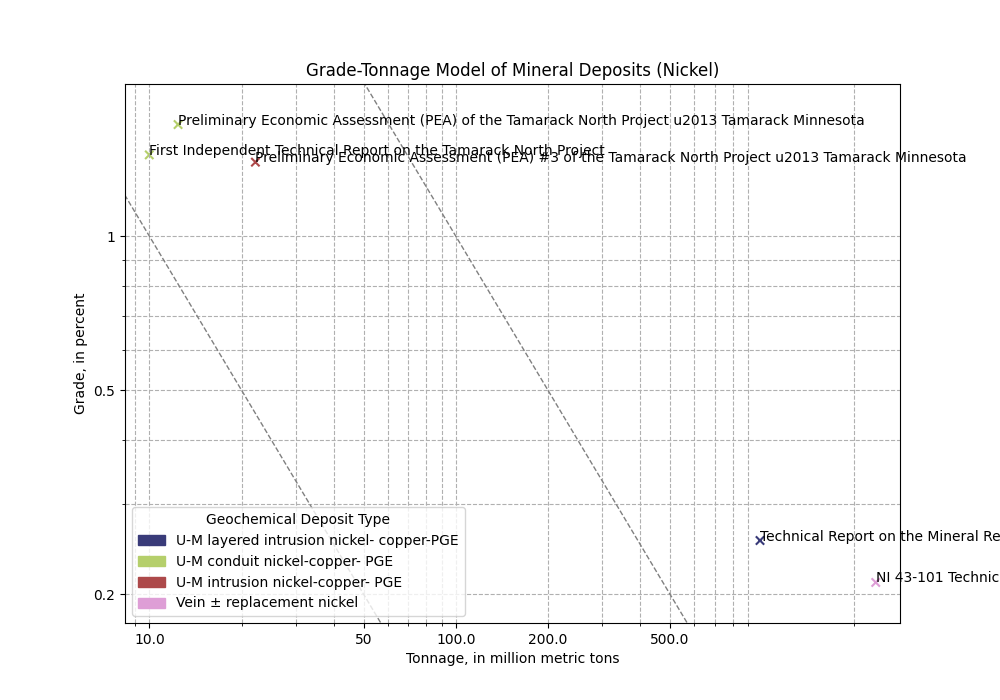

In [23]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import webbrowser

# Your existing DataFrame and data extraction
tonnages = gt_data_df['total_tonnage'].values
grades = gt_data_df['total_grade'].values
names = gt_data_df['ms_name'].values
dtnorm_labels = gt_data_df['deposit_type'].values
urls = gt_data_df['ms'].values  # URLs corresponding to each point

# Define color for each unique category in 'dtnorm_label_value'
unique_labels = gt_data_df['deposit_type'].unique()
colors = plt.cm.tab20b(np.linspace(0, 1, len(unique_labels)))  # Using 'viridis' colormap
color_map = dict(zip(unique_labels, colors))

# Create list of colors for each point
point_colors = [color_map[label] for label in dtnorm_labels]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tonnages, grades, marker='x', c=point_colors, picker=5)  # Enable picking with a tolerance of 5 points

# Logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Custom ticks for the x-axis and y-axis
x_ticks = [0.02, 0.1, 0.2, 0.5, 1, 2.0, 5.0, 10.0, 50, 100.0, 200.00, 500.00]
y_ticks = [0.02, 0.1, 0.2, 0.5, 1, 2.0, 5.0]
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.yticks(y_ticks, labels=[str(y) for y in y_ticks])

# Diagonal lines and annotations for constant tonnage-grade products
i, line_x_p, line_y_p, prev_x_p, prev_y_p = 0, 0, 0, 0, 0
product_values = [1e-2, 1e-1, 1, 10, 1e2]  # Constant tonnage-grade products to represent
for i, product in enumerate(product_values):
    # Calculate the grade at the plot's min and max tonnages for the constant product
    min_tonnage, max_tonnage = plt.xlim()
    min_grade = product / min_tonnage
    max_grade = product / max_tonnage
    # Plot the diagonal line
    plt.plot([min_tonnage, max_tonnage], [min_grade, max_grade], 'k--', lw=1, color='gray')
    # Add annotation at a specific point / todo: uncomment
    # line_x_p = np.sqrt(min_tonnage * max_tonnage)
    # line_y_p = product / np.sqrt(min_tonnage * max_tonnage)
    # if product == 10e-2:
    #     line_x_p, line_y_p = 0.1, 1
    # elif product == 10e-1:
    #     line_x_p, line_y_p = 0.5, 2
    # elif product == 10:
    #     line_x_p, line_y_p = 0.2, 50
    # line_x_p *= 1.18
    # plt.text(line_x_p, line_y_p, 
    #          f'{product*10e3} metric tons', rotation=-33, verticalalignment='bottom', horizontalalignment='right', color='gray')

# Labels and title
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")

# Annotations
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages[i], grades[i]))

# Legend
legend_handles = [mpatches.Patch(color=color_map[label], label=label) for label in unique_labels]
plt.legend(handles=legend_handles, title="Geochemical Deposit Type", loc='lower left')

# Function to open URL on click
def on_pick(event):
    ind = event.ind[0]  # Index of the picked scatter point
    url = urls[ind]
    webbrowser.open(url)  # Open the URL

# Set x-axis bounds
plt.xlim(gt_data_df['total_tonnage'].min()/1.2, gt_data_df['total_tonnage'].max()*1.2)
# Set y-axis bounds
plt.ylim(gt_data_df['total_grade'].min()/1.2, gt_data_df['total_grade'].max()*1.2)

# Connect the pick event to the on_pick function
plt.gcf().canvas.mpl_connect('pick_event', on_pick)

plt.show()

In [ ]:
# uncomment to export to csv: 
# gt_data_df.to_csv('nickel_us_gradetonnage_with_top_deposits.csv', index=False)